In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 12.4 MB/s eta 0:00:00


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.6 MB/s eta 0:00:00


In [ ]:
pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=2acaffd263a8ec0fbb38186c8582654917d7772cd3d6a90fd602516ce2fa2c95
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score


In [ ]:
#provide huggingface login
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#load libs
from datasets import load_dataset,load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import nltk
import numpy as np

In [ ]:
ds = load_dataset("multi_news")

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Dataset multi_news downloaded and prepared to /root/.cache/huggingface/datasets/multi_news/default/1.0.0/2f1f69a2bedc8ad1c5d8ae5148e4755ee7095f465c1c01ae8f85454342065a72. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model_checkpoint="facebook/bart-large-cnn"
metric=load_metric("rouge")

<ipython-input-7-90a1ed71f25c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric=load_metric("rouge")


In [ ]:
ds['train'][0]

{'document': 'National Archives \n \n Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. \n \n A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February. The unemployment rate is expected to hold steady at 8.3%. \n \n Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself, via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. \n \n Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. economy 

## Preprocessing the raw data






In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
max_news_length=1024
max_sum_length=128

#tokenize news and summary
def preprocess(dataset):
    document=[doc for doc in dataset["document"]]
    model_inputs=tokenizer(document,max_length=max_news_length,truncation=True)

    with tokenizer.as_target_tokenizer():
        labels=tokenizer(dataset["summary"],max_length=max_sum_length,truncation=True)
    model_inputs["labels"]=labels["input_ids"]
    return model_inputs
    

In [ ]:
preprocess(ds['train'][:2])

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[0, 18285, 26844, 1437, 50118, 1437, 50118, 3216, 6, 24, 17, 27, 29, 14, 86, 456, 6, 5450, 4, 85, 17, 27, 29, 5, 78, 273, 9, 5, 353, 6, 77, 13, 65, 655, 12, 2527, 12, 428, 24062, 1151, 5, 3168, 9, 2298, 852, 6, 663, 8, 4326, 852, 32, 70, 14485, 15, 65, 631, 35, 13499, 4, 1437, 50118, 1437, 50118, 83, 2310, 2935, 15, 5, 121, 4, 104, 4, 4042, 1068, 13, 644, 2323, 5, 22893, 23, 290, 35, 541, 10, 4, 119, 4, 188, 469, 86, 1839, 65, 9, 5, 144, 505, 40617, 15, 141, 5, 866, 24779, 148, 5, 986, 353, 4, 12809, 1635, 32, 13, 23041, 6, 151, 92, 1315, 7, 28, 1412, 6, 309, 7, 9019, 13829, 30, 4614, 1454, 188, 4184, 7948, 6, 1118, 7, 30398, 6, 151, 1315, 355, 11, 902, 4, 20, 5755, 731, 16, 421, 7, 946, 5204, 23, 290, 4, 246, 2153, 1437, 50118, 1437, 50118, 1398, 23, 1018, 5522, 21956, 6, 52, 17, 27, 890, 28, 1839, 3195, 9765, 137, 8, 71, 5, 414, 20238, 5, 22893, 4, 22079, 481, 7, 9832, 12, 179, 2512, 6, 1241, 5, 1450, 2810, 4, 178, 150, 47, 17, 27, 241, 259, 6, 596, 218, 17, 27, 90, 47

In [ ]:
ds_token = ds.map(preprocess, batched=True)

Map:   0%|          | 0/44972 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
ds_token

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5622
    })
})

## Exploratory Data Analysis 
Find min and max length of data and target

In [ ]:
ds_token['validation']


Dataset({
    features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5622
})

In [ ]:
import pandas as pd

# convert validation set to DataFrame
df_validation = pd.DataFrame(ds_token['validation'])

# print the DataFrame
print(df_validation.head())


                                            document  \
0  Whether a sign of a good read; or a comment on...   
1  The deaths of three American soldiers in Afgha...   
2  DUBAI Al Qaeda in Yemen has claimed responsibi...   
3  Cambridge Analytica, a data firm that worked f...   
4  The N.S.A.’s Evolution: The National Security ...   

                                             summary  \
0  – The Da Vinci Code has sold so many copies—th...   
1  – A major snafu has hit benefit payments to st...   
2  – Yemen-based al-Qaeda in the Arabian Peninsul...   
3  – Cambridge Analytica is calling it quits. The...   
4  – A lengthy report in the New York Times, base...   

                                           input_ids  \
0  [0, 18259, 10, 1203, 9, 10, 205, 1166, 131, 50...   
1  [0, 133, 3257, 9, 130, 470, 3878, 11, 4035, 42...   
2  [0, 495, 791, 3813, 100, 726, 16023, 11, 6519,...   
3  [0, 28542, 7820, 4749, 90, 2426, 6, 10, 414, 9...   
4  [0, 133, 234, 4, 104, 4, 250, 4, 17, 27, 29

##Install Libraries

In [ ]:
!pip install pandas==1.5.3
!pip install numpy==1.23.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [ ]:
#for general data analysis and dataframe manipulation
!pip install pandas-profiling --upgrade #to fix conflicts with joblib in pyldavis library
import pandas as pd

#for visualisations
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!pip install seaborn
import seaborn as sns
!pip install wordcloud 
!pip install --upgrade pyvis
!pip install networkx

#for text processing
import re #for regular expressions
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import string

#for mathematical operations
import math

#for stats
!pip install textstat

#for natural language processing
!pip install spacy 
!pip install autocorrect
!pip install TextBlob
!python -m textblob.download_corpora

#for topic modelling
import warnings
warnings.filterwarnings("ignore") 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 66.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27096 sha256=7360f00accf3ca5f506cee2e35f1e86956c08447a5bd17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622380 sha256=fcfc48205c2efa9ece2e603e2eb6218f0ac89192c1eee329b3c892989386d927
  Stored in directory: /root/.cache/pip/wheels/ab/0f/23/3c010c3fd877b962146e7765f9e9b08026cac8b035094c5750
Successfully built autocorrect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading

In [ ]:
#Look at General Info for Data Description
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5622 entries, 0 to 5621
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   document        5622 non-null   object
 1   summary         5622 non-null   object
 2   input_ids       5622 non-null   object
 3   attention_mask  5622 non-null   object
 4   labels          5622 non-null   object
dtypes: object(5)
memory usage: 219.7+ KB


In [ ]:
df_validation.describe()

,document,summary,input_ids,attention_mask,labels
count,5622,5622,5622,5622,5622
unique,5621,5622,5620,628,5622
top,Tweet with a location \n \n You can add locati...,– The Da Vinci Code has sold so many copies—th...,"[0, 44445, 19, 10, 2259, 1437, 50118, 1437, 50...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 2383, 20, 8318, 11737, 2520, 8302, 34, 108..."
freq,2,1,2,4424,1


In [ ]:
df_validation['document'].sample(10)

577     Cayman Islands (MyFoxBoston.com) -- A Massachu...
4993    × GoFundMe campaign raises more than $1.3 mill...
2151    Egypt's interim administration has published a...
1193    FILE - In this Feb. 26, 2013 file photo, Sen. ...
574     WEDNESDAYS 9/8c \n \n Black Ink Crew Chicago \...
3732    Have you ever cheered when a bad guy gets what...
247     J32, also known as Rhapsody (Photo: Center for...
4630    NEW YORK/SAN FRANCISCO The shares of daily dea...
2603    A woman who accused Herman Cain of sexual hara...
783     The Texas Board of Veterinary Medical Examiner...
Name: document, dtype: object

In [ ]:
#create a function that counts words
def word_count(text):
    wc = len(text.split())
    return wc

In [ ]:
#calculate the number of words per sentence in the df_intent dataframe
df_validation['doc_count'] = df_validation['document'].apply(word_count)

In [ ]:
df_validation['summary_count'] = df_validation['summary'].apply(word_count)

In [ ]:
df_validation['doc_count'].describe()

count      5622.000000
mean       1752.572038
std        2426.357992
min           0.000000
25%         798.000000
50%        1313.000000
75%        2065.000000
max      123120.000000
Name: doc_count, dtype: float64

In [ ]:
df_validation['summary_count'].describe()

count    5622.000000
mean      216.713803
std        67.666270
min        46.000000
25%       168.000000
50%       219.000000
75%       261.000000
max       595.000000
Name: summary_count, dtype: float64

<Axes: >

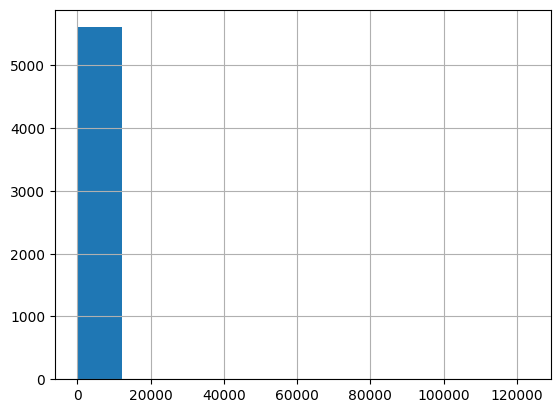

In [ ]:
#create a histogram to look at the shape of the doc_count results
df_validation['doc_count'].hist(bins = 10)

<Axes: >

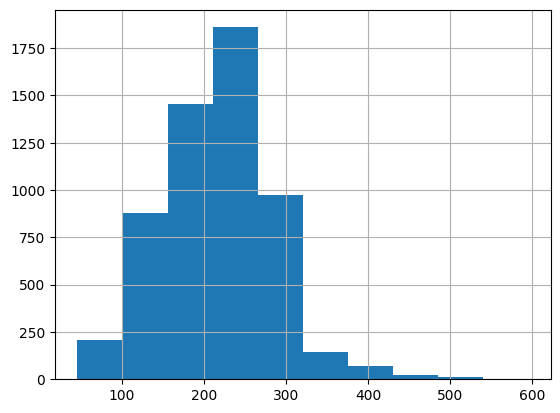

In [ ]:
df_validation['summary_count'].hist(bins = 10)

In [ ]:
#create pivot table from the df_validation dataframe to see what the average number of words are per label.
pivot_doc = df_validation.pivot_table(values='doc_count', index='document', aggfunc='mean')
print(pivot_doc)

                                                    doc_count
document                                                     
                                                            0
\n \n \n \n \n \n \n \n \n \n Further Reading A...       2078
\n \n \n \n \n \n \n \n Authorities said they f...        678
\n \n \n \n \n \n \n \n window._taboola = windo...       1416
\n \n \n \n \n \n MySpace is rolling out a comp...        527
...                                                       ...
“We’re trying to find a way through it,” said R...       5956
“Your honor, we don’t know if the suspect is th...        544
• Malcolm Turnbull sworn in as Australian Prime...       4549
• US and UK spy agencies piggyback on commercia...       2602
❮ Prev Next ❯ \n \n 20 cars that rack up ticket...       1626

[5621 rows x 1 columns]


In [ ]:
pivot_sum = df_validation.pivot_table(values='summary_count', index='summary', aggfunc='mean')
print(pivot_sum)

                                                    summary_count
summary                                                          
– " It was an absolutely cold track," a French ...            289
– "Almost all parents say that they don't favor...            238
– "Bigfoot" has been found, just not the apish ...            272
– "Bittersweet" is how Rolling Stone describes ...            199
– "Can you love your neighbor as yourself and a...            196
...                                                           ...
– “Before we get started, I need to alert @FoxN...            236
– “I really felt ashamed then, I really did,” K...            232
– “I thought he called in sick this morning, bu...            245
– “If you’re going to be put under nitrous, the...            185
– “Tired of celebrating spiritual holidays with...            186

[5622 rows x 1 columns]


In [ ]:
pivot_doc_desc = pivot_doc.sort_values(by='doc_count', ascending=False)
pivot_doc_desc.head(10)

In [ ]:
pivot_sum_desc = pivot_sum.sort_values(by='summary_count', ascending=False)
pivot_sum_desc.head(10)

In [ ]:
pivot_doc_asce = pivot_doc.sort_values(by='doc_count', ascending=True)
pivot_doc_asce.head(10)

,doc_count
document,
,0
"Starting in 1996, Alexa Internet has been donating their crawl data to the Internet Archive. Flowing in every day, these data are added to the Wayback Machine after an embargo period.",31
"Just Out: House Intelligence Committee Report released. “No evidence” that the Trump Campaign “colluded, coordinated or conspired with Russia.” Clinton Campaign paid for Opposition Research obtained from Russia- Wow! A total Witch Hunt! MUST END NOW!",36
"Crawls performed by Internet Archive on behalf of the National Library of Australia. This data is currently not publicly accessible. ||||| Starting in 1996, Alexa Internet has been donating their crawl data to the Internet Archive. Flowing in every day, these data are added to the Wayback Machine after an embargo period.",52
"Starting in 1996, Alexa Internet has been donating their crawl data to the Internet Archive. Flowing in every day, these data are added to the Wayback Machine after an embargo period. ||||| Rating is available when the video has been rented. \n \n This feature is not available right now. Please try again later.",52
"Close Get email notifications on Seth Tupper daily! \n \n Your notification has been saved. \n \n There was a problem saving your notification. \n \n Whenever Seth Tupper posts new content, you'll get an email delivered to your inbox with a link. \n \n Email notifications are only sent once a day, and only if there are new matching items.",53
"Add a location to your Tweets \n \n When you tweet with a location, Twitter stores that location. You can switch location on/off before each Tweet and always have the option to delete your location history. Learn more ||||| @ prtini: @ KennethCole is clearly out for cheap shock value. No one could be this stupid twice.",55
"The seed for this crawl was a list of every host in the Wayback Machine \n \n This crawl was run at a level 1 (URLs including their embeds, plus the URLs of all outbound links including their embeds) \n \n The WARC files associated with this crawl are not currently available to the general public. ||||| Notice \n \n You must log in to continue.",60
"Starting in 1996, Alexa Internet has been donating their crawl data to the Internet Archive. Flowing in every day, these data are added to the Wayback Machine after an embargo period. ||||| Starting in 1996, Alexa Internet has been donating their crawl data to the Internet Archive. Flowing in every day, these data are added to the Wayback Machine after an embargo period.",63


In [ ]:
pivot_sum_asce = pivot_sum.sort_values(by='summary_count', ascending=True)
pivot_sum_asce.head(10)

,summary_count
summary,
"– Travel + Leisure put together its annual America’s Favorite Cities survey, of which arguably the most interesting category is the American cities that boast the most attractive—and least attractive—residents. Click through the top five in each category in the gallery, or click here for more.",46
"– By piecing together clues from the National Enquirer's proposal story, Gawker found the $3.5 million beach house John Edwards is supposedly buying in preparation for life with Rielle Hunter. Take a guided tour in the gallery. For more pictures, click here, or check out the real estate listing.",49
"– For those who wish they were working this holiday weekend, the Labor Department has a new website aimed at helping out-of-work Americans land a job. Called My Skills, My Future, the site allows job-seekers to punch in their skills, search for jobs, and obtain training, reports Huffington Post.",49
"– The Reputation Institute is out with its annual list of the world's most reputable companies, based on a poll of 240,000 people from 15 countries. Volkswagen took a major hit, falling from the 14th spot to 123rd in 2016, per Forbes. The top 10: Rolex Disney Google BMW Daimler Lego Microsoft Canon Sony Apple",55
"– Ricky Martin finally came out, and the world said, “Duh.” On Gawker, Brian Moylan lists 10 more public figures who really need to admit they’re gay already—after all, the rest of us know. View the list in the gallery—or, for 10 more celebrities who also came out to a chorus of “Obviously!” click here.",55
"– Surprised Californians got a shake, rattle, and roll last night just before midnight when a magnitude 4.4 earthquake hit northern Orange County. There were no immediate reports of injuries or damage, but the rattler and a 2.7 aftershock a minute later were definitely felt over a broad region, including downtown LA, reports the Los Angeles Times.",57
"– With Betty White hosting, Saturday Night Live drew its best ratings of the season and the largest audience since Nov. 1, 2008, when John McCain appeared with the Tina Fey version of then-running mate Sarah Palin. The broadcast thrashed not just its time-slot competitors but also every primetime show, reports Entertainment Weekly. Your move, Alec Baldwin.",57
"– Remember, oh, way back on Monday, when Owen Wilson announced he and his girlfriend were preggers? Well, they're not anymore: Us reports that Wilson and Jade Duell welcomed a son yesterday at his property in Hawaii, which apparently allowed him to keep the baby bump a secret. No name as yet, but click for other details.",57
"– It's not every day you get to see an iceberg flip upside down, but a tourist in Argentina did just that and posted the results on YouTube. It took place near the Upsala Glacier in Los Glaciares National Park, notes the Daily Mail. The Huffington Post says the iceberg flipped after a part of the glacier broke away.",59


In [ ]:
#create a function to populate bar graph from dataframe variable
from collections import Counter
from nltk.corpus import stopwords

def wordBarGraphFunction(df,column,title):
    label_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(label_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

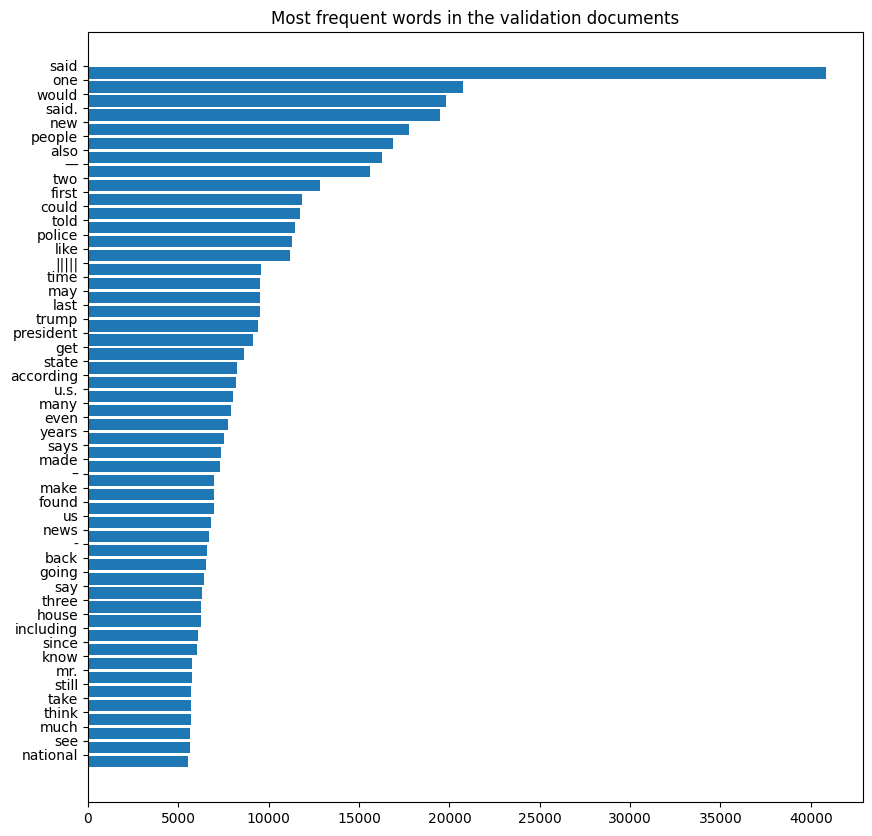

In [ ]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(df_validation,"document","Most frequent words in the validation documents")

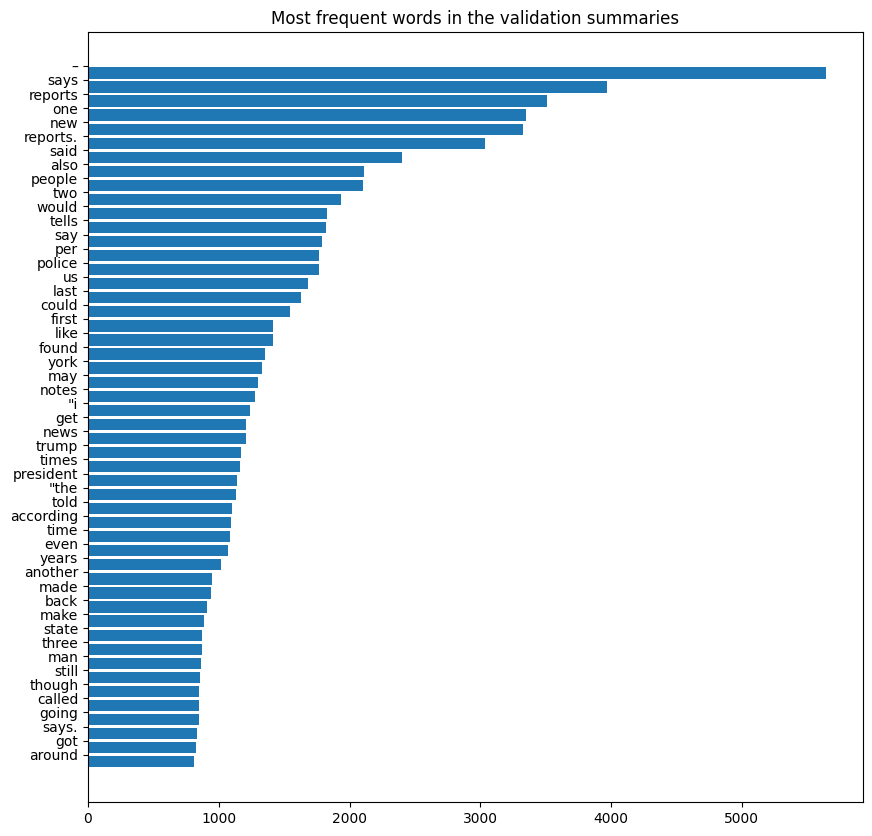

In [ ]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(df_validation,"summary","Most frequent words in the validation summaries")

In [ ]:
#Using the sort function - view the shortest sentences
df_validation.sort_values(by='doc_count').head(20)

In [ ]:
df_validation.sort_values(by='summary_count').head(20)

In [ ]:
#reversing this sort will show the longest
df_validation.sort_values(by='doc_count', ascending=False).head(20)

In [ ]:
df_validation.sort_values(by='summary_count', ascending=False).head(20)

In [ ]:
#check for nulls
df_validation.isnull().sum()

document          0
summary           0
input_ids         0
attention_mask    0
labels            0
doc_count         0
summary_count     0
dtype: int64

In [ ]:
#set the variable stop with English language stopwords as the texts are in English.
stop=stopwords.words("english")

In [ ]:
#create a function to plot the most common stop words
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

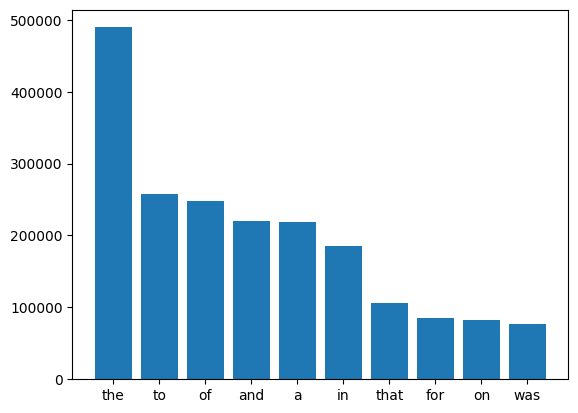

In [ ]:
#show the plot of most common stopwords within the df_validation
plot_top_stopwords_barchart(df_validation['document'])

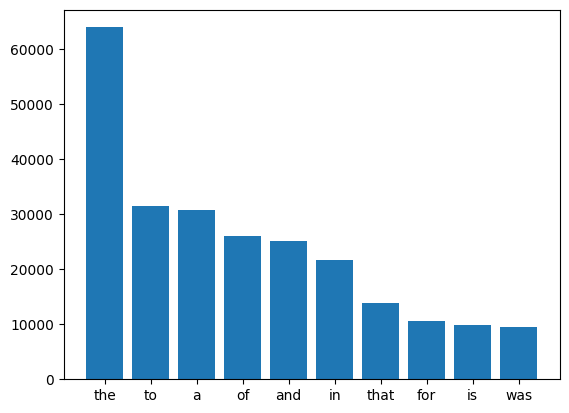

In [ ]:
plot_top_stopwords_barchart(df_validation['summary'])

In [ ]:
corpus_doc=[]
new= df_validation['document'].str.split()
new=new.values.tolist()
corpus_doc=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus_doc:
    if word in stop:
        dic[word]+=1

In [ ]:
corpus_sum=[]
new_sum= df_validation['summary'].str.split()
new_sum=new_sum.values.tolist()
corpus_sum=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus_sum:
    if word in stop:
        dic[word]+=1

<Axes: >

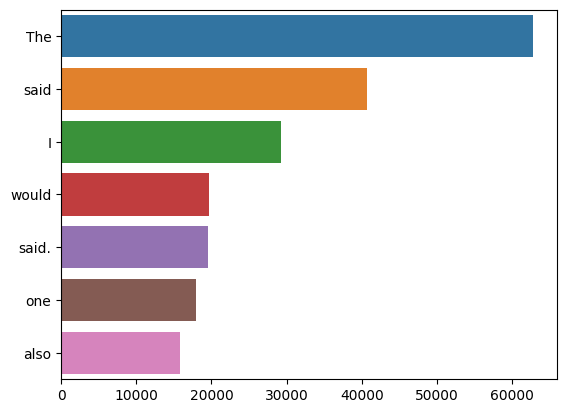

In [ ]:
#Most common words in the sentence (a.k.a. Word frequencies)
#using the counter function from the collections library that will count and store the occurance of each word within the defined corpus
counter=Counter(corpus_doc)
most=counter.most_common()
#plot the most frequent words
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

<Axes: >

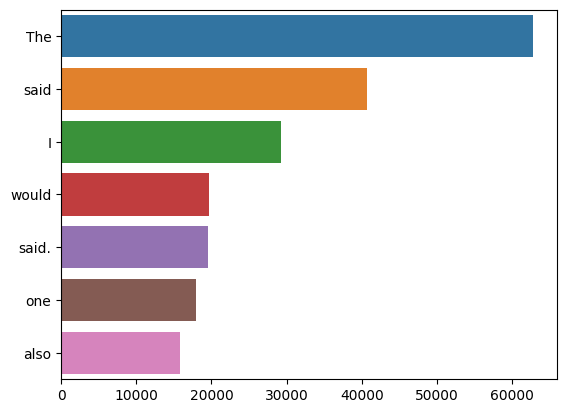

In [ ]:
#Most common words in the sentence (a.k.a. Word frequencies)
#using the counter function from the collections library that will count and store the occurance of each word within the defined corpus
counter=Counter(corpus_sum)
most=counter.most_common()
#plot the most frequent words
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [ ]:
# converting series to string
doc_text = df_validation['document'].to_string()
sum_text = df_validation['summary'].to_string()

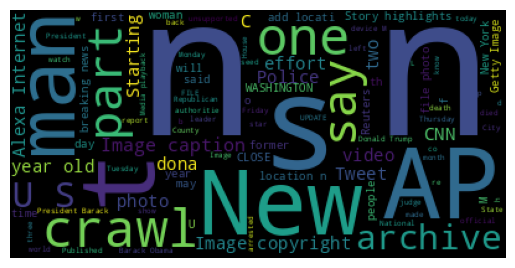

In [ ]:
#wordcloud of most common words
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=100).generate(doc_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

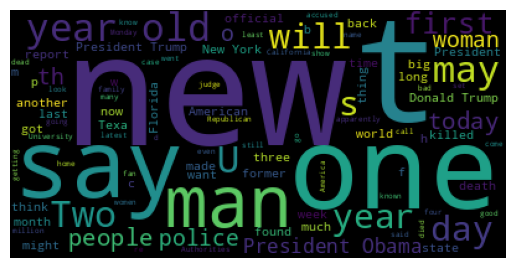

In [ ]:
wordcloud_sum = WordCloud(max_words=100).generate(sum_text)
plt.imshow(wordcloud_sum)
plt.axis("off")
plt.show()

In [ ]:
#explore n-grams
from sklearn.feature_extraction.text import CountVectorizer
#using the CountVectorizer function from the sklearn library, create a function that takes a corpus and returns a n-gram bar chart of the 20 most frequent n-grams
def get_top_ngram(corpus_doc, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus_doc)
    bag_of_words = vec.transform(corpus_doc)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

<Axes: >

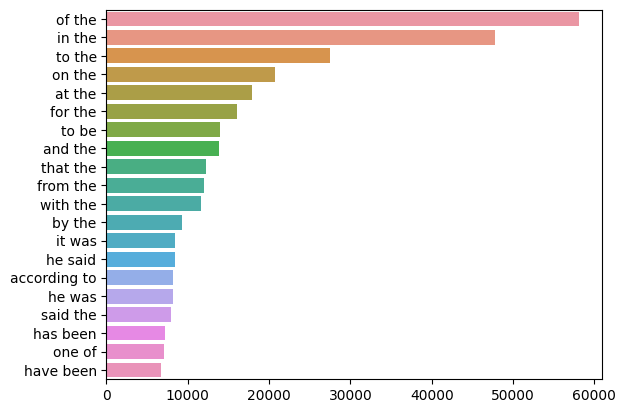

In [ ]:
top_bi_grams=get_top_ngram(df_validation['document'],n=2)
x,y=map(list,zip(*top_bi_grams))
sns.barplot(x=y,y=x)

<Axes: >

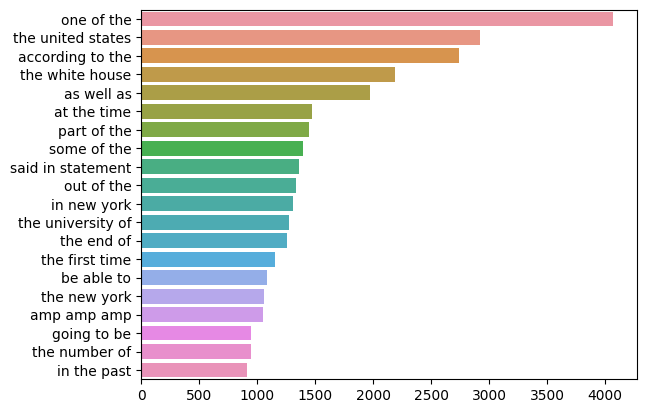

In [ ]:
top_tri_grams=get_top_ngram(df_validation['document'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

<Axes: >

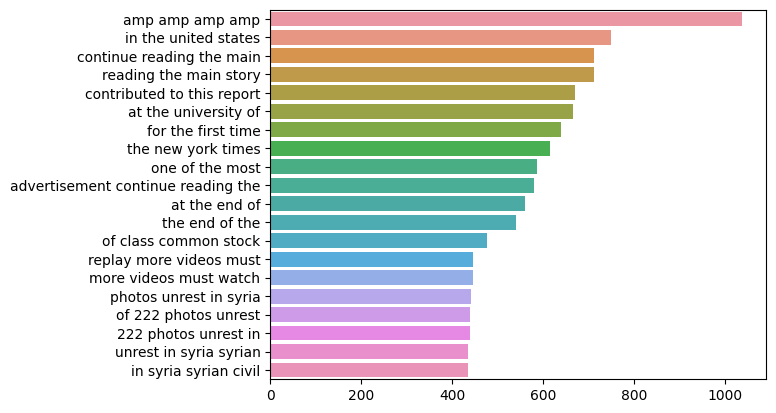

In [ ]:
top_quad_grams=get_top_ngram(df_validation['document'],n=4)
x,y=map(list,zip(*top_quad_grams))
sns.barplot(x=y,y=x)

In [ ]:
# converting sentence text to lowercase as Python is case-sensitive
doc_lower = doc_text.lower()

#create word tokens
tokenized_words_doc=word_tokenize(doc_lower)

In [ ]:
# converting sentence text to lowercase as Python is case-sensitive
sum_lower = sum_text.lower()

#create word tokens
tokenized_words_sum=word_tokenize(sum_lower)

In [ ]:
#Create a new variable to store filtered tokens 
filtered_doc_tokens=[]
for w in tokenized_words_doc:    
    if w not in stop:
         #add all filtered tokens excluding stopwords in this list below
         filtered_doc_tokens.append(w)

In [ ]:
#Create a new variable to store filtered tokens 
filtered_sum_tokens=[]
for w in tokenized_words_sum:    
    if w not in stop:
         #add all filtered tokens excluding stopwords in this list below
         filtered_sum_tokens.append(w)

In [ ]:
# Remove punctuations
remove_punctuation_doc = [words for words in filtered_doc_tokens if words.isalpha()]
remove_punctuation_sum = [words for words in filtered_sum_tokens if words.isalpha()]

In [ ]:
#Adding new stopwords, in the context of the corpus, vacinate and all its derrived words as well as COVID and COVID-19
#does not add meaning to the corpus as this is implied by the dataset so these have been removed to see what other insights
#may crop up.
new_stops = ["the"]
stop.extend(new_stops)

In [ ]:
# Remove custom stop words
removing_custom_words_sum = [words for words in remove_punctuation_sum if not words in stop]
print(removing_custom_words_sum)

['da', 'vinci', 'code', 'sold', 'many', 'major', 'snafu', 'hit', 'benefit', 'payments', 'st', 'arabian', 'peninsul', 'cambridge', 'analytica', 'calling', 'quits', 'lengthy', 'report', 'new', 'york', 'times', 'base', 'juan', 'de', 'oñate', 'sought', 'city', 'gold', 'another', 'bad', 'day', 'anthony', 'weiner', 'nancy', 'pe', 'augmented', 'reality', 'startup', 'sued', 'f', 'length', 'man', 'index', 'ring', 'fingers', 'lawyer', 'suing', 'united', 'airline', 'according', 'two', 'university', 'mississippi', 'r', 'former', 'colorado', 'sheriff', 'patrick', 'sullivan', 'may', 'day', 'vital', 'democratic', 'primary', 'vote', 'democrats', 'opposed', 'president', 'george', 'w', 'trying', 'lose', 'weight', 'iphone', 'available', 'sprint', 'n', 'reviews', 'last', 'night', 'emmy', 'awa', 'dime', 'minted', 'sold', 'feel', 'like', 'monogamy', 'keeping', 'ex', 'member', 'gutted', 'stomach', 'slic', 'nicole', 'oulson', 'spoke', 'yesterday', 'cast', 'characters', 'david', 'afghanistan', 'vet', 'sentence

In [ ]:
# Remove custom stop words
removing_custom_words_doc = [words for words in remove_punctuation_doc if not words in stop]
print(removing_custom_words_doc)

['whether', 'sign', 'good', 'read', 'comment', 'deaths', 'three', 'american', 'soldiers', 'afgha', 'dubai', 'al', 'qaeda', 'yemen', 'claimed', 'responsibi', 'cambridge', 'analytica', 'data', 'firm', 'worked', 'f', 'evolution', 'national', 'security', 'remaining', 'thank', 'readi', 'anthony', 'weiner', 'rejected', 'democratic', 'leader', 'augmented', 'reality', 'startup', 'magic', 'leap', 'research', 'suggests', 'ratio', 'length', 'houston', 'almost', 'two', 'years', 'ago', 'pair', 'unit', 'deshazo', 'bigler', 'work', 'published', 'sheriff', 'known', 'break', 'msnbc', 'town', 'hall', 'taping', 'janet', 'napolitano', 'three', 'months', 'tulane', 'university', 'school', 'public', 'health', 'sprint', 'nextel', 'begin', 'selling', 'new', 'neil', 'patrick', 'harris', 'hot', 'streak', 'ce', 'dime', 'carson', 'city', 'displa', 'contrary', 'popular', 'belief', 'people', 'ope', 'gunfire', 'rang', 'forysth', 'county', 'courtho', 'inflatable', 'santas', 'put', 'months', 'befor', 'tampa', 'like', '

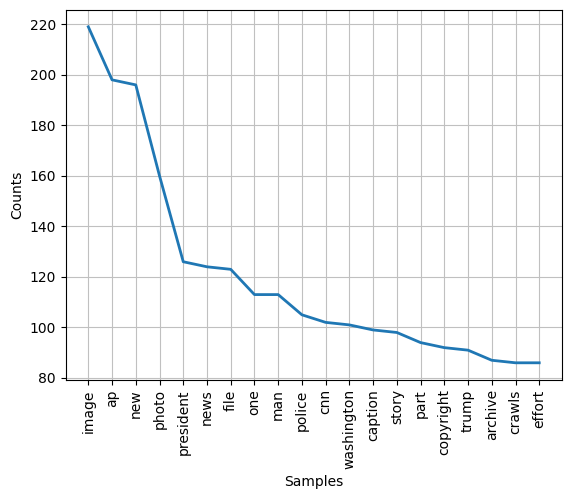

[('image', 219), ('ap', 198), ('new', 196), ('photo', 160), ('president', 126), ('news', 124), ('file', 123), ('one', 113), ('man', 113), ('police', 105), ('cnn', 102), ('washington', 101), ('caption', 99), ('story', 98), ('part', 94), ('copyright', 92), ('trump', 91), ('archive', 87), ('crawls', 86), ('effort', 86)]


In [ ]:
all_words=nltk.FreqDist(removing_custom_words_doc)
all_words.plot(20);
print(all_words.most_common(20))

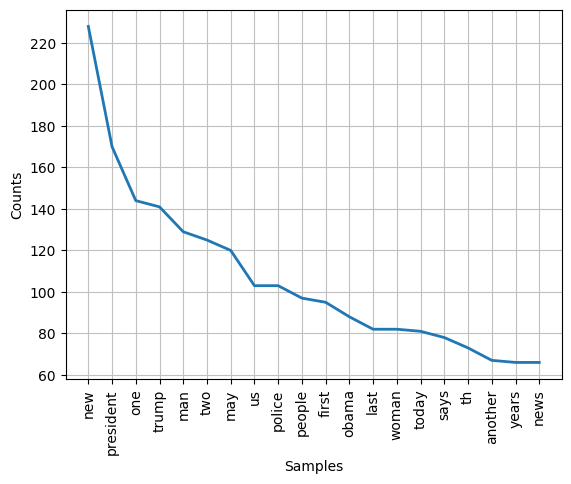

[('new', 228), ('president', 170), ('one', 144), ('trump', 141), ('man', 129), ('two', 125), ('may', 120), ('us', 103), ('police', 103), ('people', 97), ('first', 95), ('obama', 88), ('last', 82), ('woman', 82), ('today', 81), ('says', 78), ('th', 73), ('another', 67), ('years', 66), ('news', 66)]


In [ ]:
all_words=nltk.FreqDist(removing_custom_words_sum)
all_words.plot(20);
print(all_words.most_common(20))

In [ ]:
# import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
doc_lem = [lemmatizer.lemmatize(word) for word in removing_custom_words_doc]

<Axes: >

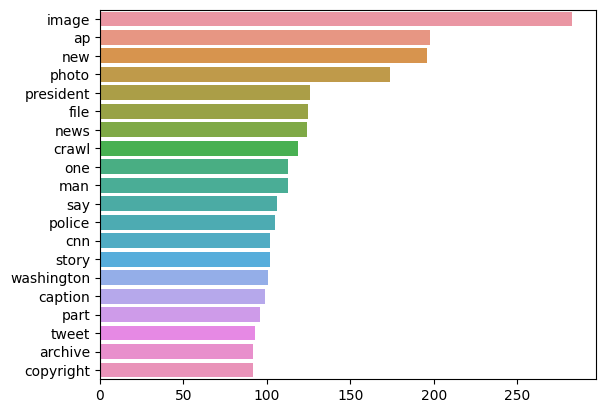

In [ ]:
#re-examine the word frequencies after lemmatisation
counter=Counter(doc_lem)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [ ]:
sum_lem = [lemmatizer.lemmatize(word) for word in removing_custom_words_sum]

<Axes: >

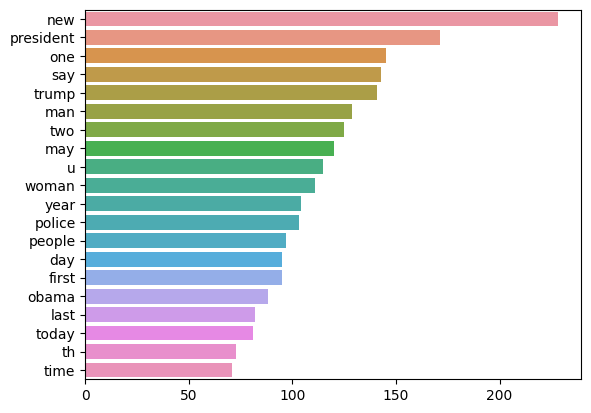

In [ ]:
#re-examine the word frequencies after lemmatisation
counter=Counter(sum_lem)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

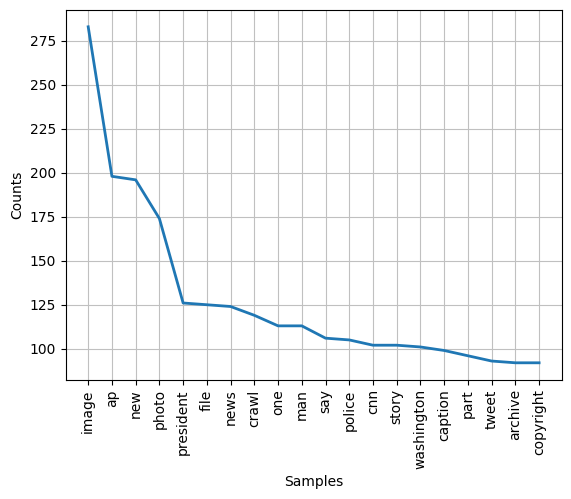

[('image', 283), ('ap', 198), ('new', 196), ('photo', 174), ('president', 126), ('file', 125), ('news', 124), ('crawl', 119), ('one', 113), ('man', 113), ('say', 106), ('police', 105), ('cnn', 102), ('story', 102), ('washington', 101), ('caption', 99), ('part', 96), ('tweet', 93), ('archive', 92), ('copyright', 92)]


In [ ]:
all_words_doc=nltk.FreqDist(doc_lem)
all_words_doc.plot(20);
print(all_words_doc.most_common(20))

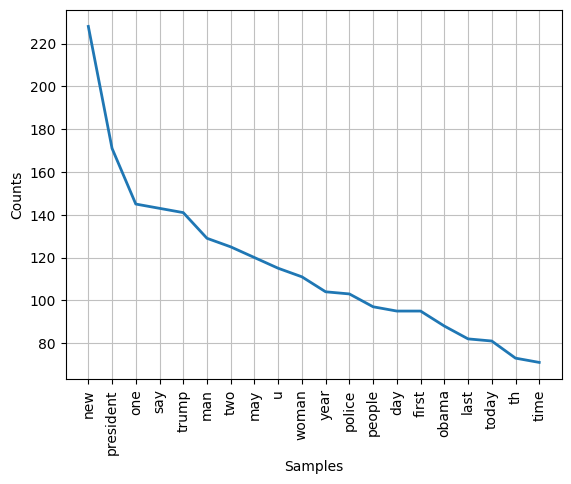

[('new', 228), ('president', 171), ('one', 145), ('say', 143), ('trump', 141), ('man', 129), ('two', 125), ('may', 120), ('u', 115), ('woman', 111), ('year', 104), ('police', 103), ('people', 97), ('day', 95), ('first', 95), ('obama', 88), ('last', 82), ('today', 81), ('th', 73), ('time', 71)]


In [ ]:
all_words_sum=nltk.FreqDist(sum_lem)
all_words_sum.plot(20);
print(all_words_sum.most_common(20))

In [ ]:
from nltk.collocations import *
bi_gram_measures = nltk.collocations.BigramAssocMeasures()
tri_gram_measures = nltk.collocations.TrigramAssocMeasures()
quad_gram_measures = nltk.collocations.QuadgramAssocMeasures()
finder_doc = BigramCollocationFinder.from_words(doc_lem)
finder_sum = BigramCollocationFinder.from_words(sum_lem)

In [ ]:
#Using PMI scores to quantify and rank the bi-grams
finder_doc.nbest(bi_gram_measures.pmi, 50)

[('aaa', 'reminds'),
 ('aachen', 'strangler'),
 ('aback', 'remembered'),
 ('abdirahmaan', 'muhumed'),
 ('abrupt', 'shift'),
 ('absurd', 'thanksgivin'),
 ('accepted', 'huma'),
 ('ace', 'guitarist'),
 ('achieve', 'fligh'),
 ('acknowled', 'property'),
 ('acord', 'tee'),
 ('addressed', 'berni'),
 ('adhere', 'masculine'),
 ('adjunct', 'palatka'),
 ('admirer', 'gracious'),
 ('admission', 'oath'),
 ('adnan', 'syed'),
 ('adobe', 'flash'),
 ('adored', 'bootylicious'),
 ('adrienne', 'elrod'),
 ('aedes', 'aegypti'),
 ('aegypti', 'mosquito'),
 ('affability', 'maki'),
 ('affordable', 'stylish'),
 ('afraa', 'bilan'),
 ('agave', 'syr'),
 ('ah', 'trifle'),
 ('aim', 'heavily'),
 ('aircraft', 'carrier'),
 ('ajak', 'deng'),
 ('akai', 'gurley'),
 ('alana', 'honey'),
 ('alber', 'taeniasis'),
 ('alejandro', 'ortega'),
 ('alicia', 'mundy'),
 ('alien', 'civili'),
 ('alison', 'sider'),
 ('allen', 'ripped'),
 ('allende', 'exhumation'),
 ('allentown', 'lehigh'),
 ('alsip', 'hollister'),
 ('alternative', 'sweeten

In [ ]:
finder_sum.nbest(bi_gram_measures.pmi, 50)

[('aaden', 'moreno'),
 ('abby', 'sunderland'),
 ('abdullah', 'saleh'),
 ('abercrombie', 'fitch'),
 ('abstinence', 'acrobat'),
 ('achieved', 'equality'),
 ('acknowledges', 'microcephaly'),
 ('acord', 'detailed'),
 ('acrobat', 'juggler'),
 ('acros', 'judd'),
 ('admit', 'imbibing'),
 ('admits', 'falling'),
 ('adrian', 'peterson'),
 ('adriana', 'coronad'),
 ('adul', 'otto'),
 ('affidavit', 'yahya'),
 ('aggressive', 'performance'),
 ('ah', 'qwikster'),
 ('airbnb', 'commitment'),
 ('alanis', 'morissette'),
 ('alexei', 'navalny'),
 ('alexia', 'truax'),
 ('alfonso', 'cuaron'),
 ('allege', 'mountaineer'),
 ('allowing', 'underage'),
 ('allows', 'assisted'),
 ('alton', 'sterl'),
 ('amazed', 'discover'),
 ('amina', 'arra'),
 ('anakin', 'skywalker'),
 ('ananda', 'marchildon'),
 ('andie', 'macdowell'),
 ('andrea', 'constand'),
 ('anecdotal', 'evi'),
 ('angel', 'colombia'),
 ('angelika', 'graswald'),
 ('announcer', 'mocked'),
 ('anonymously', 'contributed'),
 ('anorexi', 'decidedly'),
 ('anry', 'fuen

In [ ]:
#word associations bi_gram
from nltk import BigramAssocMeasures
bi_gram_measures = BigramAssocMeasures()
finder_doc = BigramCollocationFinder.from_words(doc_lem)

finder_doc.nbest(bi_gram_measures.likelihood_ratio, 20)

[('effort', 'archive'),
 ('starting', 'alexa'),
 ('part', 'effort'),
 ('internet', 'dona'),
 ('alexa', 'internet'),
 ('crawl', 'part'),
 ('story', 'highlight'),
 ('image', 'caption'),
 ('image', 'copyright'),
 ('add', 'locati'),
 ('location', 'add'),
 ('tweet', 'location'),
 ('playback', 'unsupported'),
 ('unsupported', 'device'),
 ('medium', 'playback'),
 ('new', 'york'),
 ('breaking', 'news'),
 ('donald', 'trump'),
 ('file', 'photo'),
 ('barack', 'obama')]

In [ ]:
finder_sum = BigramCollocationFinder.from_words(sum_lem)

finder_sum.nbest(bi_gram_measures.likelihood_ratio, 20)

[('donald', 'trump'),
 ('president', 'obama'),
 ('president', 'trump'),
 ('new', 'york'),
 ('north', 'korea'),
 ('hillary', 'clinton'),
 ('mitt', 'romney'),
 ('white', 'house'),
 ('pope', 'francis'),
 ('police', 'officer'),
 ('sarah', 'palin'),
 ('look', 'like'),
 ('good', 'news'),
 ('vladimir', 'putin'),
 ('san', 'francisco'),
 ('los', 'angeles'),
 ('herman', 'cain'),
 ('south', 'carolina'),
 ('taylor', 'swift'),
 ('supreme', 'court')]

In [ ]:
#word associations tri_gram
from nltk import TrigramAssocMeasures
tri_gram_measures = TrigramAssocMeasures()
finder_doc = TrigramCollocationFinder.from_words(doc_lem)

finder_doc.nbest(tri_gram_measures.likelihood_ratio,50)

[('part', 'effort', 'archive'),
 ('alexa', 'internet', 'dona'),
 ('starting', 'alexa', 'internet'),
 ('crawl', 'part', 'effort'),
 ('location', 'add', 'locati'),
 ('tweet', 'location', 'add'),
 ('playback', 'unsupported', 'device'),
 ('medium', 'playback', 'unsupported'),
 ('getty', 'image', 'copyright'),
 ('effort', 'archive', 'president'),
 ('effort', 'archive', 'apparent'),
 ('effort', 'archive', 'cannes'),
 ('effort', 'archive', 'developing'),
 ('effort', 'archive', 'georgetown'),
 ('effort', 'archive', 'hiroko'),
 ('effort', 'archive', 'lamar'),
 ('effort', 'archive', 'malfunction'),
 ('effort', 'archive', 'missionary'),
 ('effort', 'archive', 'pal'),
 ('effort', 'archive', 'patron'),
 ('effort', 'archive', 'pretzel'),
 ('effort', 'archive', 'revisiting'),
 ('effort', 'archive', 'cardi'),
 ('effort', 'archive', 'cher'),
 ('effort', 'archive', 'mount'),
 ('effort', 'archive', 'randy'),
 ('effort', 'archive', 'screenshot'),
 ('effort', 'archive', 'vin'),
 ('effort', 'archive', 'wash

In [ ]:
finder_sum = TrigramCollocationFinder.from_words(sum_lem)

finder_sum.nbest(tri_gram_measures.likelihood_ratio,50)

[('donald', 'trump', 'doubling'),
 ('president', 'obama', 'made'),
 ('donald', 'trump', 'apparently'),
 ('donald', 'trump', 'tweeted'),
 ('president', 'obama', 'benjamin'),
 ('president', 'obama', 'sat'),
 ('donald', 'trump', 'may'),
 ('tuesday', 'donald', 'trump'),
 ('president', 'obama', 'continued'),
 ('president', 'donald', 'trump'),
 ('donald', 'trump', 'latest'),
 ('absorb', 'donald', 'trump'),
 ('av', 'donald', 'trump'),
 ('dial', 'donald', 'trump'),
 ('donald', 'trump', 'assured'),
 ('donald', 'trump', 'bask'),
 ('donald', 'trump', 'clarifying'),
 ('donald', 'trump', 'deadbeat'),
 ('donald', 'trump', 'embro'),
 ('donald', 'trump', 'jr'),
 ('donald', 'trump', 'minor'),
 ('endorsing', 'donald', 'trump'),
 ('fill', 'donald', 'trump'),
 ('gunn', 'donald', 'trump'),
 ('horrif', 'donald', 'trump'),
 ('jubilant', 'donald', 'trump'),
 ('naacp', 'donald', 'trump'),
 ('norw', 'donald', 'trump'),
 ('predicta', 'donald', 'trump'),
 ('rai', 'donald', 'trump'),
 ('reg', 'donald', 'trump'),
 

In [ ]:
# Ngrams with 'archive' as a member
word_filter = lambda *w: 'archive' not in w

finder_doc = TrigramCollocationFinder.from_words(doc_lem)

# only tri-grams that appear 3+ times
finder_doc.apply_freq_filter(3)
# only tri-grams that contain 'archive'
finder_doc.apply_ngram_filter(word_filter)

# return the n-grams with the highest PMI
for i in finder_doc.score_ngrams(tri_gram_measures.likelihood_ratio):
    assoc_word = (i)
    print (assoc_word)

(('part', 'effort', 'archive'), 2089.8236724104586)
(('effort', 'archive', 'president'), 1054.3376183041155)
(('effort', 'archive', 'washington'), 1045.8568739524137)
(('effort', 'archive', 'new'), 1042.483762549976)
(('archive', 'president', 'barack'), 364.7753531761793)


In [ ]:
# Ngrams with 'president' as a member
word_filter = lambda *w: 'president' not in w

finder_sum = TrigramCollocationFinder.from_words(sum_lem)

# only tri-grams that appear 3+ times
finder_sum.apply_freq_filter(3)
# only tri-grams that contain 'president'
finder_sum.apply_ngram_filter(word_filter)

# return the n-grams with the highest PMI
for i in finder_sum.score_ngrams(tri_gram_measures.likelihood_ratio):
    assoc_word = (i)
    print (assoc_word)

(('president', 'obama', 'made'), 672.1472686191162)
(('president', 'donald', 'trump'), 664.1443635553126)
(('president', 'trump', 'signed'), 538.5442697432997)


In [ ]:
# return the bi-grams with the highest PMI
result_doc = []
finder_doc = BigramCollocationFinder.from_words(doc_lem)
for i in finder_doc.score_ngrams(bi_gram_measures.likelihood_ratio):
    assoc_word = (i)
    result_doc.append(i)
    #print (assoc_word)

In [ ]:
result_sum = []
finder_sum = BigramCollocationFinder.from_words(sum_lem)
for i in finder_sum.score_ngrams(bi_gram_measures.likelihood_ratio):
    assoc_word = (i)
    result_sum.append(i)
    #print (assoc_word)

In [ ]:
#convert results to dataframe
df_result_doc = pd.DataFrame(result_doc, columns = ["word_pair","likelihood"])
df_result_sum = pd.DataFrame(result_sum, columns = ["word_pair","likelihood"])

In [ ]:
#convert the word_pair to a string
df_result_doc['word_pair'] = df_result_doc['word_pair'].map(str)
df_result_sum['word_pair'] = df_result_sum['word_pair'].map(str)

In [ ]:
#split the string using regex and append to dataframe
df_result_doc[['source', 'target']] = df_result_doc['word_pair'].str.extract('\(\'(.*?)\',\s*\'(.*?)\'\)', expand=True)
print(df_result_doc)

                   word_pair   likelihood    source    target
0      ('effort', 'archive')  1037.285469    effort   archive
1      ('starting', 'alexa')  1025.538571  starting     alexa
2         ('part', 'effort')  1020.079526      part    effort
3       ('internet', 'dona')   994.052943  internet      dona
4      ('alexa', 'internet')   983.378960     alexa  internet
...                      ...          ...       ...       ...
23541     ('image', 'woman')     0.005460     image     woman
23542       ('image', 'cnn')     0.002670     image       cnn
23543     ('image', 'story')     0.002670     image     story
23544     ('story', 'image')     0.002670     story     image
23545     ('image', 'tweet')     0.001722     image     tweet

[23546 rows x 4 columns]


In [ ]:
df_result_sum[['source', 'target']] = df_result_sum['word_pair'].str.extract('\(\'(.*?)\',\s*\'(.*?)\'\)', expand=True)
print(df_result_sum)

                    word_pair  likelihood     source     target
0         ('donald', 'trump')  651.509433     donald      trump
1      ('president', 'obama')  649.606263  president      obama
2      ('president', 'trump')  510.826603  president      trump
3             ('new', 'york')  506.709997        new       york
4          ('north', 'korea')  300.936415      north      korea
...                       ...         ...        ...        ...
24270       ('police', 'new')    0.012816     police        new
24271         ('new', 'year')    0.010781        new       year
24272         ('year', 'new')    0.010781       year        new
24273    ('one', 'president')    0.003608        one  president
24274            ('new', 'u')    0.000020        new          u

[24275 rows x 4 columns]


In [ ]:
result_doc_500 = df_result_doc.sort_values(by='likelihood', ascending=False).head(500)
result_sum_500 = df_result_sum.sort_values(by='likelihood', ascending=False).head(500)

In [ ]:
result_doc_500

,word_pair,likelihood,source,target
0,"('effort', 'archive')",1037.285469,effort,archive
1,"('starting', 'alexa')",1025.538571,starting,alexa
2,"('part', 'effort')",1020.079526,part,effort
3,"('internet', 'dona')",994.052943,internet,dona
4,"('alexa', 'internet')",983.378960,alexa,internet
...,...,...,...,...
495,"('said', 'thursday')",24.890610,said,thursday
496,"('kim', 'kanye')",24.781904,kim,kanye
497,"('known', 'break')",24.781904,known,break
498,"('homeless', 'man')",24.739280,homeless,man


In [ ]:
result_sum_500

,word_pair,likelihood,source,target
0,"('donald', 'trump')",651.509433,donald,trump
1,"('president', 'obama')",649.606263,president,obama
2,"('president', 'trump')",510.826603,president,trump
3,"('new', 'york')",506.709997,new,york
4,"('north', 'korea')",300.936415,north,korea
...,...,...,...,...
1168,"('pioneer', 'rober')",22.357346,pioneer,rober
1169,"('pioneering', 'centenarian')",22.357346,pioneering,centenarian
1170,"('piper', 'verdusco')",22.357346,piper,verdusco
1172,"('plagiarizing', 'wikipedia')",22.357346,plagiarizing,wikipedia


In [ ]:
import networkx as nx
#load dataframe as graph
#graph top 500 word associations
graph_doc = nx.from_pandas_edgelist(result_doc_500,
                                      source = 'source',
                                      target = 'target',
                                      edge_attr='likelihood')
graph_sum = nx.from_pandas_edgelist(result_sum_500,
                                      source = 'source',
                                      target = 'target',
                                      edge_attr='likelihood')

In [ ]:
#THE CODE IS QUICK TO RUN LIKE A FOX - THE IMAGE IS SLOW AS A SLUG.
#worth the wait.
import pyvis
from pyvis.network import Network
from IPython.core.display import HTML

net_doc = Network(notebook=True, cdn_resources='in_line')
net_doc.from_nx(graph_doc)
net_doc.show("bi_grams_doc.html")
#quirk in Google colab - need to display generated HTML to work.
display(HTML("bi_grams_doc.html"))

bi_grams_doc.html


In [ ]:
net_sum = Network(notebook=True, cdn_resources='in_line')
net_sum.from_nx(graph_sum)
net_sum.show("bi_grams_sum.html")
#quirk in Google colab - need to display generated HTML to work.
display(HTML("bi_grams_sum.html"))

bi_grams_sum.html


##Data Description

In [ ]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5622 entries, 0 to 5621
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   document        5622 non-null   object
 1   summary         5622 non-null   object
 2   input_ids       5622 non-null   object
 3   attention_mask  5622 non-null   object
 4   labels          5622 non-null   object
 5   doc_count       5622 non-null   int64 
 6   summary_count   5622 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 307.6+ KB
